In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.linalg
import scipy.stats as scs
from multiprocessing import Pool, cpu_count
from Heston_CIR import interest_rate_path, stock_path

We consider $\textbf{Heston model with stochastic interest rate}$ given by the following stochastic differential equations:
\begin{eqnarray*}dS\left(t\right)&=&r\left(t\right)S\left(t\right)dt+\sqrt{\nu\left(t\right)}S\left(t\right)dW^{S}\left(t\right)\\dr\left(t\right)&=&\alpha\left(\beta-r\left(t\right)\right)dt+\sigma\sqrt{r\left(t\right)}dW^{r}\left(t\right)\\d\nu\left(t\right)&=&\kappa\left(\theta-\nu\left(t\right)\right)dt+\xi\sqrt{\nu\left(t\right)}dW^{\nu}\left(t\right)\end{eqnarray*}
where $W^S, W^r, W^{\nu}$ are Wiener processes (can be correlated) and $\alpha, \beta, \sigma, \kappa, \theta, \xi \ge 0$/

In [4]:
# Data
S0 = 100
r0 = 0.1
v0 = 0.04
beta = 0.05
alpha = 1.0
sigma = 0.2
kappa = 0.5
theta = 0.3
xi = 0.2
rho_S_r = -0.3
rho_S_v = -0.5
rho_r_v = 0.2
N = 252
M = 100000
T = 1
method = "zero" 

params = {"S0": S0,
          "r0": r0,
          "v0": v0,
          "beta": beta,
          "alpha": alpha,
          "sigma": sigma,
          "kappa": kappa,
          "theta": theta,
          "xi": xi,
          "rho_S_r": rho_S_r,
          "rho_S_v": rho_S_v,
          "rho_r_v": rho_r_v,
          "N": N,
          "M": M,
          "T": T,
          "method": method}

# Paths of interest rate ($r$)

In [5]:
num_proc = cpu_count()
print("CPUs' number: ", num_proc)

start = time.time()

params_ = []
for i in range(M):
    params_.append(params)

threads = num_proc - 1

p = Pool(threads)
print("Number of CPUs' used:", threads)

results = p.map_async(interest_rate_path, params_)
results = np.asarray(results.get())

t_ = results[0, 0]  # time grid
r_paths_ = np.vstack([results[i, 1] for i in range(M)])  # interest rate paths
DFs_ = np.vstack([results[i, 2] for i in range(M)])[:, 0]  # discount factors

end = time.time()
print("Computation time : ", end - start, " s")

CPUs' number:  4
Number of CPUs' used: 3
Computation time :  107.07371354103088  s


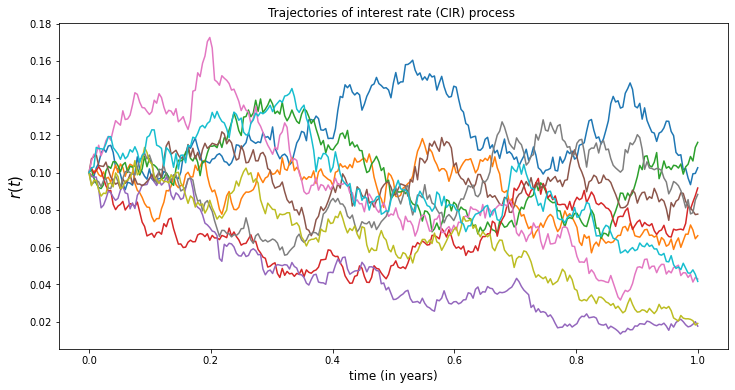

In [6]:
plt.figure(figsize = (12, 6))
for i in range(10):
    plt.plot(t_, r_paths_[i, :])
plt.xlabel('time (in years)', size = 12)
plt.ylabel('$r(t)$', size = 15)
plt.title("Trajectories of interest rate (CIR) process ", size = 12)
plt.show()

# Zero-coupon Bond

If the short-rate is modelled by CIR process

$$dr\left(t\right)=\alpha\left(\beta-r\left(t\right)\right)dt+\sigma\sqrt{r\left(t\right)}dW^{r}\left(t\right),$$
then the price of a zero-coupon bond is given by the following formula:

$$P\left(t,T\right)=A\left(t,T\right)e^{-r\left(t\right)B\left(t,T\right)},$$
where
\begin{eqnarray*}A\left(t,T\right)&=&\left(\frac{2\gamma\exp\left\{ \frac{\left(\gamma+\alpha\right)\left(T-t\right)}{2}\right\} }{2\gamma+\left(\gamma+\alpha\right)\left(e^{\gamma\left(T-t\right)}-1\right)}\right)^{\frac{2\alpha\beta}{\sigma^{2}}}\\B\left(t,T\right)&=&\frac{2\left(e^{\gamma\left(T-t\right)}-1\right)}{2\gamma+\left(\gamma+\alpha\right)\left(e^{\gamma\left(T-t\right)}-1\right)}\\\gamma&=&\sqrt{\alpha^{2}+2\sigma^{2}}\end{eqnarray*}

In [7]:
gamma = np.sqrt(alpha ** 2 + 2 * sigma ** 2)

def A(t, T):
    return ((2 * gamma * np.exp((gamma + alpha) * (T - t) / 2)) / (2 * gamma + (gamma + alpha) * (np.exp(gamma * (T - t)) - 1))) ** (2 * alpha * beta / sigma ** 2)

def B(t, T):
    return (2 * (np.exp(gamma * (T - t)) - 1)) / (2 * gamma + (gamma + alpha) * (np.exp(gamma * (T - t)) - 1))

def P(t, T, r_t):
    return A(t, T) * np.exp(-r_t * B(t, T))

In [8]:
F = 100 # Face value
price = F * P(0, T, r0)
print("The exact price of a zero-coupon bond with maturity T =",T, "and face value F =" ,F,"is P(0,T) = %5.3f." %price)

The exact price of a zero-coupon bond with maturity T = 1 and face value F = 100 is P(0,T) = 92.191.


In [9]:
price_MC = F * np.mean(DFs_)
emp_std = np.sqrt(np.sum((F * DFs_ - price_MC) ** 2) / (M - 1))
standard_error = emp_std / np.sqrt(M)
I1 = price_MC - 1.96 * standard_error
I2 = price_MC + 1.96 * standard_error

print("The MC price of a zero-coupon bond with maturity T =",T, "and face value F =" ,F,"is P(0,T) = %5.3f." %price_MC)
print("Standard error = %5.3f" %standard_error)
print("95% confidence interval: [{:.2f},".format(I1),"{:.2f}]".format(I2))

The MC price of a zero-coupon bond with maturity T = 1 and face value F = 100 is P(0,T) = 92.180.
Standard error = 0.007
95% confidence interval: [92.17, 92.19]


# Coupon Bond

If we assume that our bond in fixed times $T_{1},...,T_{N}$ such that
$$0=T_{0}<T_{1}<...<T_{N-1}<T_{N}=T$$
pays fixed coupons $C_{1},...,C_{N}$ where $C_i=c \cdot F$ ($c$ - coupon rate), then $$P^{\text{coupon}}\left(0,T\right)=\sum_{i=1}^{N}C_{i}P\left(0,T_{i}\right)+FP\left(0,T\right)$$

In [10]:
# Data 
Maturity = 10
c = 0.04
F = 100
coupons_per_year = 2

In [11]:
def coupon_bond(T, c, F, coupons_per_year, r0):
    N = coupons_per_year * T
    C = c / coupons_per_year * F
    time = np.linspace(0, T, N + 1)
    time = time[1:]
    Price = F * P(0, T, r0)
    for t in time:
        Price += C * P(0, t, r0)
    return Price

In [12]:
price = coupon_bond(Maturity, c, F, coupons_per_year, r0)
print("The exact price of a coupon bond with parameters: T =",Maturity,", F =" ,F,", c =", c,", m =", coupons_per_year, \
      "is P(0,T) = %5.3f." %price)

The exact price of a coupon bond with parameters: T = 10 , F = 100 , c = 0.04 , m = 2 is P(0,T) = 88.058.


In [13]:
# Trajectories for coupon bond
m = coupons_per_year * Maturity  # number of payments 
density = 20
N_ = m * density  # number of time steps should be a multiple of the number of payments 

# We take the same parameters as earlier...
params_bond = dict(params) 

#... but we change T and N 
params_bond["T"] = Maturity 
params_bond["N"] = N_

params_ = []
for i in range(M):
    params_.append(params_bond)
    
results = p.map_async(interest_rate_path, params_)
results = np.asarray(results.get())

t_bond = results[0, 0] 
r_paths_bond = np.vstack([results[i, 1] for i in range(M)])

In [14]:
# Pricing coupon bond by MC simulations
h_bond = Maturity / N_
C = c / coupons_per_year * F

# Cash-flows at maturity
r_integral_bond = h_bond * np.sum(r_paths_bond[:, :-1], axis = 1)
DFs_bond = np.exp(-r_integral_bond)
prices_MC = (F + C) * DFs_bond

# Earlier coupons
for i in range(1, m):
    r_integral_bond = h_bond * np.sum(r_paths_bond[:, :(i * density)], axis = 1)
    DFs_bond = np.exp(-r_integral_bond)
    prices_MC += C * DFs_bond

price_MC = np.mean(prices_MC)

emp_std = np.sqrt(np.sum((prices_MC - price_MC) ** 2) / (M - 1))
standard_error = emp_std / np.sqrt(M)
I1 = price_MC - 1.96 * standard_error
I2 = price_MC + 1.96 * standard_error

print("The MC price of a coupon bond with parameters: T =",Maturity,", F =" ,F,", c =", c,", m =", coupons_per_year, \
      "is P(0,T) = %5.3f." %price_MC)
print("Standard error = %5.3f" %standard_error)
print("95% confidence interval: [{:.2f},".format(I1),"{:.2f}]".format(I2))

The MC price of a coupon bond with parameters: T = 10 , F = 100 , c = 0.04 , m = 2 is P(0,T) = 88.065.
Standard error = 0.031
95% confidence interval: [88.01, 88.13]


# Expected Value and Variance of $r(t)$

The Expected Value and Variance of $r(t)$ for $t\ge 0$ are given by the following formulas:
\begin{eqnarray*}\mathbb{E}\left(r\left(t\right)\right)&=&r\left(0\right)e^{-\alpha t}+\beta\left(1-e^{-\alpha t}\right)\\\text{Var}\left(r\left(t\right)\right)&=&r\left(0\right)\frac{\sigma^{2}}{\alpha}\left(e^{-\alpha t}-e^{-2\alpha t}\right)+\frac{\sigma^{2}\beta}{2\alpha}\left(1-e^{-\alpha t}\right)^{2}\end{eqnarray*}

In [15]:
def E(r0, t):
    return r0 * np.exp(-alpha * t) + beta * (1 - np.exp(-alpha * t))

def Var(r0, t):
    return r0 * sigma ** 2 / alpha * (np.exp(-alpha * t) - np.exp(-2 * alpha * t)) + sigma ** 2 * beta / (2 * alpha) * (1 - np.exp(-alpha * t)) ** 2

def Std(r0, t):
    return np.sqrt(Var(r0, t))

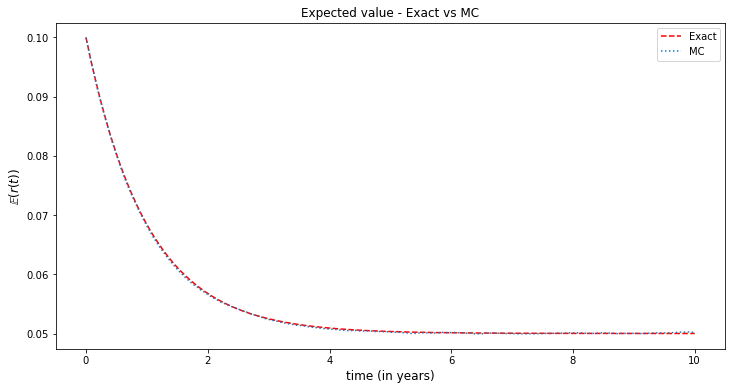

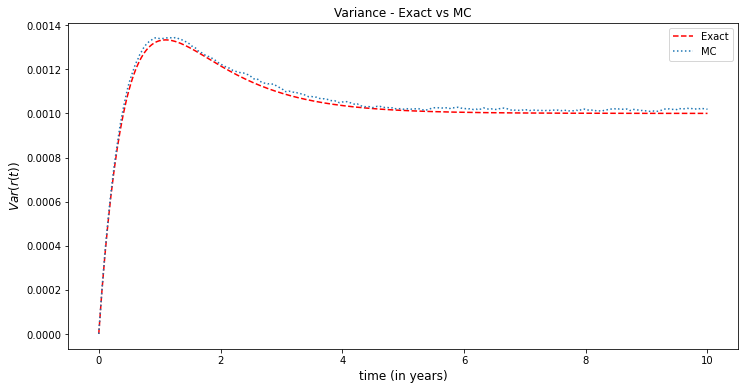

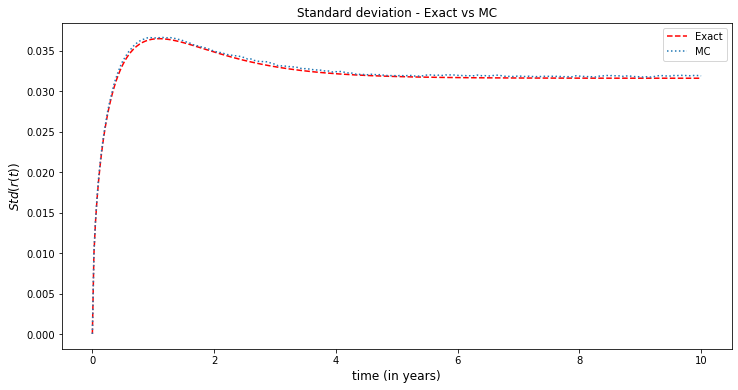

In [16]:
EV = E(r0, t_bond)
Variance = Var(r0, t_bond)
Stand_dev = Std(r0, t_bond)

sample_EV = np.mean(r_paths_bond, axis = 0)
sample_Var = np.var(r_paths_bond, axis = 0)
sample_Std = np.std(r_paths_bond, axis = 0)

plt.figure(figsize= (12, 6))
plt.plot(t_bond, EV, linestyle = "--", color = "r", label = "Exact")
plt.plot(t_bond, sample_EV, label = "MC", linestyle = "dotted")
plt.legend()
plt.xlabel('time (in years)', size = 12)
plt.ylabel('$\mathbb{E}(r(t))$', size = 12)
plt.title("Expected value - Exact vs MC", size = 12)
plt.show()

plt.figure(figsize= (12, 6))
plt.plot(t_bond, Variance, linestyle = "--", color = "r", label = "Exact")
plt.plot(t_bond, sample_Var, label = "MC", linestyle = "dotted")
plt.legend()
plt.xlabel('time (in years)', size = 12)
plt.ylabel('$Var(r(t))$', size = 12)
plt.title("Variance - Exact vs MC", size = 12)
plt.show()

plt.figure(figsize= (12, 6))
plt.plot(t_bond, Stand_dev, linestyle = "--", color = "r", label = "Exact")
plt.plot(t_bond, sample_Std, label = "MC", linestyle = "dotted")
plt.legend()
plt.xlabel('time (in years)', size = 12)
plt.ylabel("$Std(r(t))$", size = 12)
plt.title("Standard deviation - Exact vs MC", size = 12)
plt.show()

# Paths of stock price ($S$)

### Correlated Wiener processes

In [17]:
# I method (Cholesky decomposition)

start = time.time()

rho_S_r = -0.3
rho_S_v = -0.5
rho_r_v = 0.2

h = T / N
sq_h = np.sqrt(h)

corr_matrix = [[1, rho_S_r, rho_S_v],
               [rho_S_r, 1, rho_r_v],
               [rho_S_v, rho_r_v, 1]]

L = scipy.linalg.cholesky(corr_matrix, lower = True)

M_ = 1000

W_S = np.zeros((M_, N + 1))
W_r = np.zeros((M_, N + 1))
W_v = np.zeros((M_, N + 1))

W_S[:, 0] = 0
W_r[:, 0] = 0
W_v[:, 0] = 0

cor_S_r = np.zeros(M_)
cor_S_v = np.zeros(M_)
cor_r_v = np.zeros(M_)

for i in range(M_):
    for j in range(N):
        Normals = np.random.normal(0, 1, 3) 
        Normals = np.matmul(L, Normals)
        W_S[i, j + 1] += sq_h * Normals[0]
        W_r[i, j + 1] += sq_h * Normals[1]
        W_v[i, j + 1] += sq_h * Normals[2]
    cor_S_r[i] = scipy.stats.pearsonr(W_S[i, :], W_r[i, :])[0]
    cor_S_v[i] = scipy.stats.pearsonr(W_S[i, :], W_v[i, :])[0]
    cor_r_v[i] = scipy.stats.pearsonr(W_r[i, :], W_v[i, :])[0]

end = time.time()

print("Computation time : ", end - start, " s")
print("Correlations: {:.2f}".format(np.mean(cor_S_r)), "{:.2f}".format(np.mean(cor_S_v)), "{:.2f}".format(np.mean(cor_r_v)))

Computation time :  3.9294912815093994  s
Correlations: -0.30 -0.50 0.20


In [18]:
# II method (using np.random.multivariate_normal)

start = time.time()

rho_S_r = -0.3
rho_S_v = -0.5
rho_r_v = 0.2
    
cov = [[1, rho_S_r, rho_S_v],
       [rho_S_r, 1, rho_r_v],
       [rho_S_v, rho_r_v, 1]]

mean = [0, 0, 0]

M_ = 1000

W_S = np.zeros((M_, N + 1))
W_r = np.zeros((M_, N + 1))
W_v = np.zeros((M_, N + 1))

W_S[:, 0] = 0
W_r[:, 0] = 0
W_v[:, 0] = 0

cor_S_r = np.zeros(M_)
cor_S_v = np.zeros(M_)
cor_r_v = np.zeros(M_)

for i in range(M_):
    for j in range(N):
        Normals = np.random.multivariate_normal(mean, cov)
        W_S[i, j + 1] += sq_h * Normals[0]
        W_r[i, j + 1] += sq_h * Normals[1]
        W_v[i, j + 1] += sq_h * Normals[2]
    cor_S_r[i] = scipy.stats.pearsonr(W_S[i, :], W_r[i, :])[0]
    cor_S_v[i] = scipy.stats.pearsonr(W_S[i, :], W_v[i, :])[0]
    cor_r_v[i] = scipy.stats.pearsonr(W_r[i, :], W_v[i, :])[0]
    
end = time.time()

print("Computation time : ", end - start, " s")
print("Correlations: {:.2f}".format(np.mean(cor_S_r)), "{:.2f}".format(np.mean(cor_S_v)), "{:.2f}".format(np.mean(cor_r_v)))

# We can see that Cholesky decomposition is much faster so we will use method I for simulation

Computation time :  38.22206902503967  s
Correlations: -0.30 -0.50 0.20


In [19]:
# Stock trajectories

num_proc = cpu_count()
print("CPUs' number: ", num_proc)

start = time.time()

params_ = []
for i in range(M):
    params_.append(params)

threads = num_proc - 1

p = Pool(threads)
print("Number of CPUs' used:", threads)

results = p.map_async(stock_path, params_)
results = np.asarray(results.get())

t = results[0, 0]
S_paths = np.vstack([results[i, 1] for i in range(M)])
r_paths = np.vstack([results[i, 2] for i in range(M)])
v_paths = np.vstack([results[i, 3] for i in range(M)])
DFs = np.vstack([results[i, 4] for i in range(M)])[:, 0]

end = time.time()
print("Computation time : ", end - start, " s")

CPUs' number:  4
Number of CPUs' used: 3
Computation time :  348.674516916275  s


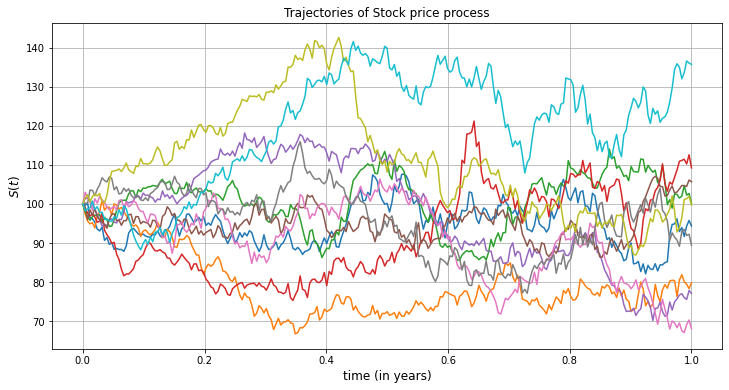

In [20]:
plt.figure(figsize = (12, 6))
for i in range(10):
    plt.plot(t, S_paths[i, :])
plt.xlabel('time (in years)', size = 12)
plt.ylabel('$S(t)$', size = 12)
plt.title("Trajectories of Stock price process", size = 12)
plt.grid()
plt.show()

##  European Options

In [21]:
K = 100  # strike

### Call

In [22]:
def Call_payoff(x, K):
    tmp = x - K
    tmp = np.where(tmp < 0, 0.0, tmp)

    return tmp

In [23]:
Payoffs = DFs * Call_payoff(S_paths[:, -1], K)
Call_Price = np.mean(Payoffs)

emp_std = np.sqrt(np.sum((Payoffs - Call_Price) ** 2) / (M - 1))
standard_error = emp_std / np.sqrt(M)
I1 = Call_Price - 1.96 * standard_error
I2 = Call_Price + 1.96 * standard_error

print("European call option price = %5.3f" %Call_Price)
print("Standard error = %5.3f" %standard_error)
print("95% confidence interval: [{:.2f},".format(I1),"{:.2f}]".format(I2))

European call option price = 15.678
Standard error = 0.069
95% confidence interval: [15.54, 15.81]


### Put

In [24]:
def Put_payoff(x, K):
    tmp = K - x
    tmp = np.where(tmp < 0, 0.0, tmp)

    return tmp

In [25]:
Payoffs = DFs * Put_payoff(S_paths[:, -1], K)
Put_Price = np.mean(Payoffs)

emp_std = np.sqrt(np.sum((Payoffs - Put_Price) ** 2) / (M - 1))
standard_error = emp_std / np.sqrt(M)
I1 = Put_Price - 1.96 * standard_error
I2 = Put_Price + 1.96 * standard_error

print("European put option price = %5.3f" %Put_Price)
print("Standard error = %5.3f" %standard_error)
print("95% confidence interval: [{:.2f},".format(I1),"{:.2f}]".format(I2))

European put option price = 7.948
Standard error = 0.040
95% confidence interval: [7.87, 8.03]


### Put-Call Parity

$$C_{0}-P_{0}=S_{0}-Ke^{-\int_{0}^{T}r_{s}ds}$$

In [26]:
DF = np.mean(DFs)

L = Call_Price - Put_Price
R = S0 - K * DF 

print(L - R)

# The difference is close to 0, so it looks OK.

-0.08151517618104176


# American Options (Longstaff-Schwartz Least Square MC, 2001)

### Call

In [36]:
h = T / N

# Intristic value
I = np.maximum(S_paths - K, 0)

# Present Value Vector (Initialization)
V = I[:, -1]

# American Option Valuation by Backwards Induction
for t in range(N - 1, 0, -1):
    indexes = np.where(I[:, t] > 0)[0]  # indexes of In-the-money trajectories
    DF = np.exp(-r_paths[:, t] * h)   # discount factors from time t+1 to t
    newV = V * DF
    reg = np.polyfit(S_paths[indexes, t], newV[indexes], 4)
    C = np.polyval(reg, S_paths[indexes, t]) # continuation values
    newV[indexes] = np.where(I[indexes, t] > C, I[indexes, t], newV[indexes])
    V = newV

V0 = np.exp(-r0 * h) * np.sum(V) / M # LSM estimator
print("American call option value %5.3f" % V0)

American call option value 15.610


In [37]:
# Laquerre polynomials

h = T / N

# Intristic value
I = np.maximum(S_paths - K, 0)

# Present Value Vector (Initialization)
V = I[:, -1]

# American Option Valuation by Backwards Induction
for t in range(N - 1, 0, -1):
    indexes = np.where(I[:, t] > 0)[0]  # indexes of In-the-money trajectories
    DF = np.exp(-r_paths[:, t] * h)   # discount factors
    reg = np.polynomial.laguerre.lagfit(S_paths[indexes, t], V[indexes] * DF[indexes], 9)
    C = np.polynomial.laguerre.lagval(S_paths[indexes, t], reg) # continuation values
    newV = V * DF
    newV[indexes] = np.where(I[indexes, t] > C, I[indexes, t], newV[indexes])
    V = newV
# exercise decision
V0 = np.exp(-r0 * h) * np.sum(V) / M # LSM estimator
print("American put option value %5.3f" % V0)

American put option value 15.707


### Put

In [38]:
h = T / N

# Intristic value
I = np.maximum(K - S_paths, 0)

# Present Value Vector (Initialization)
V = I[:, -1]

# American Option Valuation by Backwards Induction
for t in range(N - 1, 0, -1):
    indexes = np.where(I[:, t] > 0)[0]  # indexes of In-the-money trajectories
    DF = np.exp(-r_paths[:, t] * h)   # discount factors
    newV = V * DF
    reg = np.polyfit(S_paths[indexes, t], newV[indexes], 4)
    C = np.polyval(reg, S_paths[indexes, t]) # continuation values
    newV[indexes] = np.where(I[indexes, t] > C, I[indexes, t], newV[indexes])
    V = newV

V0 = np.exp(-r0 * h) * np.sum(V) / M # LSM estimator
print("American put option value %5.3f" % V0)

American put option value 8.467


In [39]:
# Laquerre polynomials

h = T / N

# Intristic value
I = np.maximum(K - S_paths, 0)

# Present Value Vector (Initialization)
V = I[:, -1]

# American Option Valuation by Backwards Induction
for t in range(N - 1, 0, -1):
    indexes = np.where(I[:, t] > 0)[0]  # indexes of In-the-money trajectories
    DF = np.exp(-r_paths[:, t] * h)   # discount factors
    reg = np.polynomial.laguerre.lagfit(S_paths[indexes, t], V[indexes] * DF[indexes], 9)
    C = np.polynomial.laguerre.lagval(S_paths[indexes, t], reg) # continuation values
    newV = V * DF
    newV[indexes] = np.where(I[indexes, t] > C, I[indexes, t], newV[indexes])
    V = newV
# exercise decision
V0 = np.exp(-r0 * h) * np.sum(V) / M # LSM estimator
print("American put option value %5.3f" % V0)

American put option value 8.461


In [40]:
# Metoda bez pobierania indeksów!

K = 100
h = T / N
# Intristic value
I = np.maximum(K - S_paths, 0)
# Present Value Vector (Initialization)
V = I[:, -1]
# American Option Valuation by Backwards Induction
for t in range(N - 1, 0, -1):
    df = np.exp(-r_paths[:, t] * h)
    reg = np.polyfit(S_paths[:, t], V * df, 5)
    C = np.polyval(reg, S_paths[:, t]) # continuation values
    V = np.where(I[:, t] > C, I[:, t], V * df)
# exercise decision
V0 = np.exp(-r0 * h) * np.sum(V) / M # LSM estimator
print("American put option value %5.3f" % V0)

American put option value 8.154


# Appendix (not used functions)

In [295]:
# generating M interest rate paths without multiprocessing 

def interest_rate_paths(params):
    r0 = params["r0"]
    beta = params["beta"]
    alpha = params["alpha"]
    sigma = params["sigma"]
    M = params["M"]
    N = params["N"]
    T = params["T"]
    method = params["method"]

    t = np.linspace(0, T, N + 1)
    h = float(T / N)
    sq_h = np.sqrt(h)
        
    r = np.zeros((M, N + 1))
    r[:, 0] = r0

    for i in range(M):
        for j in range(N):
            Normal = np.random.normal() 
            r[i, j + 1] = r[i, j] + alpha * (beta - r[i, j]) * h + sigma * np.sqrt(r[i, j]) * sq_h * Normal + 0.25 * sigma ** 2 * h * (Normal ** 2 - 1)
            if r[i, j + 1] < 0:
                if method == "abs":
                    r[i, j + 1] = np.abs(r[i, j + 1])
                elif method == "zero":
                    r[i, j + 1] = 0
                    
    r_integral = h * np.sum(r[:, :-1], axis = 1)
    DFs = np.exp(-r_integral)
    return t, r, DFs

In [53]:
# generating M stock paths without multiprocessing 

def stock_paths(params):
    S0 = params["S0"]
    r0 = params["r0"]
    v0 = params["v0"]
    r0 = params["r0"]
    beta = params["beta"]
    alpha = params["alpha"]
    sigma = params["sigma"]
    kappa = params["kappa"]
    theta = params["theta"]
    xi = params["xi"]
    M = params["M"]
    N = params["N"]
    T = params["T"]
    method = params["method"]

    t = np.linspace(0, T, N + 1)
    h = float(T / N)
    sq_h = np.sqrt(h)
    
    rho_S_r = 0.5
    rho_S_v = -0.7
    rho_r_v = 0.1

#     mean = [0, 0 , 0]
#     cov = [[1, rho_S_r, rho_S_v],
#                    [rho_S_r, 1, rho_r_v],
#                    [rho_S_v, rho_r_v, 1]]

    corr_matrix = [[1, rho_S_r, rho_S_v],
                   [rho_S_r, 1, rho_r_v],
                   [rho_S_v, rho_r_v, 1]]
    
    L = scipy.linalg.cholesky(corr_matrix, lower = True)
    
    r = np.zeros((M, N + 1))
    v = np.zeros((M, N + 1))
    S = np.zeros((M, N + 1))

    r[:, 0] = r0
    v[:, 0] = v0
    S[:, 0] = S0
    for i in range(M):
        for j in range(N):
            Normals = np.random.normal(0, 1, 3)
            Normals = np.matmul(L, Normals) 
#             Normals = np.random.multivariate_normal(mean, cov)
            r[i, j + 1] = r[i, j] + alpha * (beta - r[i, j]) * h + sigma * np.sqrt(r[i, j]) * sq_h * Normals[1] + 0.25 * sigma ** 2 * h * (Normals[1] ** 2 - 1)
            v[i, j + 1] = v[i, j] + kappa * (theta - r[i, j]) * h + xi * np.sqrt(v[i, j]) * sq_h * Normals[2] + 0.25 * xi ** 2 * h * (Normals[2] ** 2 - 1)

            if r[i, j + 1] < 0:
                if method == "abs":
                    r[i, j + 1] = np.abs(r[i, j + 1])
                elif method == "zero":
                    r[i, j + 1] = 0

            if v[i, j + 1] < 0:
                if method == "abs":
                    v[i, j + 1] = np.abs(r[i, j + 1])
                elif method == "zero":
                    v[i, j + 1] = 0

            S[i, j + 1] = S[i, j] + r[i, j] * S[i, j] * h + np.sqrt(v[i, j]) * S[i, j] * sq_h * Normals[0] + 0.5 * v[i, j] * S[i, j] * h * (Normals[0] ** 2 - 1)
    
    r_integral = h * np.sum(r[:, :-1], axis = 1)
    DFs = np.exp(-r_integral)
    
    return t, S, r, v, DFs